# Collect and Analyze a Twitter Network
[Effrosyni Simou](http://lts4.epfl.ch/simou), *PhD Student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [328]:
%matplotlib inline

import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tweepy  # you will need to install tweepy first
import collections

In [2]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [499]:
user = 'appliedmldays '

user_id=api.get_user(user).id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [206]:
def find_connections(my_user_id,page_max):
    # gets the number of followers and friends
    followers = []
    friends = []
    
    cursor_friends = tweepy.Cursor(api.friends_ids, id=my_user_id, count=5000)
    for page in cursor_friends.pages(page_max):
        friends = friends + page
    
    cursor_followers = tweepy.Cursor(api.followers_ids, id=my_user_id, count=5000)
    for page in cursor_followers.pages(page_max):
        followers = followers + page
        
    # computes the intersection of those 2 sets : number of connections
    connections = list(set(friends) & set(followers))
    return connections

In [207]:
first_connections=find_connections(user_id,4)
print('{} has {} connections'.format(user, len(first_connections)))


appliedmldays  has 139 connections


Here we add a function that we will use indore to check if the user is not to "big" or not too "small", this uses 1 query,but will allow us not to fall on a too large connection (like a 1M followers account). This kind of connection would lead to a very long wait because we can only get 5000 users by page. This allows us to garantee later that we have downloaded all the connections of one user and that it was not limited by the number of pages in the cursor. 

In [315]:
def check_user(connect_user,min_num,max_num):
    # check if user has protection of its tweets and if it has min/max number of followers/friends
    User = api.get_user(connect_user);
    if  (not User.protected) & \
        (min_num  < User.followers_count < max_num) &\
        (min_num  < User.friends_count < max_num):
            
        #print("follower : " + str(User.followers_count))
        #print("friends : " + str(User.friends_count))
        return True
    else:
        #print("follower : " + str(User.followers_count))
        #print("friends : " + str(User.friends_count))
        return False
    

Here we add a function that created a random list of users, checking that i is in the linits set by the previous function, and taking care of of unicity of the members in the list. 

In [321]:
def random_list(original_list,n_limit,min_num,max_num):
    random_chosen_list = []
    rejected_list = []
    
    while (len(random_chosen_list) < n_limit)  :
        potential_choice = random.choice(list(set(original_list) - set(random_chosen_list) - set(rejected_list)))
        if check_user(potential_choice,min_num,max_num):
            random_chosen_list += [potential_choice]
        else :
            rejected_list += [potential_choice]

    return random_chosen_list
                
            

Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [470]:
original_network = {}
first_nodes=[]
eliminated_first_nodes =[]
second_nodes=[]
how_many= 10     #This is the number of connections you are sampling.
                #Keep small (e.g.3) for development, larger later (e.g. 10)
page_max = 4;
max_num = page_max*5000
min_num = how_many

while len(first_nodes) < how_many :
    # taking a potential 1st connection node.
    potential_first_node = random.choice(list(set(first_connections) - set(first_nodes) - set(eliminated_first_nodes)))
    
    # check if user has minimum or maximum number of followers and friends (not connections)
    if check_user(potential_connection,min_num,max_num):
        # If the number is okay, then we can take all the connections of this node 
        potential_second_nodes = find_connections(potential_first_node,page_max)
        
        # we decide to eliminate the nodes that don't have enough connections 
        if len(potential_second_nodes) >= min_num : 
            
            my_second_nodes = random_list(potential_second_nodes,how_many,min_num,max_num)
            first_nodes += [potential_first_node] # We add the first node found to the list 
            second_nodes += my_second_nodes # We add the second nodes found to the list 
            original_network[potential_first_node] = my_second_nodes # We create the network entry
            
            # printing the nodes
            print('+ ' + str(potential_first_node))
            print("|+ " + str(my_second_nodes))
            
        else: 
            eliminated_first_nodes += [potential_connection] # add the potential connection to the eleminated list
        
    else: 
        eliminated_first_nodes += [potential_connection] # add the potential connection to the eleminated list

+ 2533212240
|+ [255051048, 112683173, 1316984629, 2287331420, 599665849, 178525062, 149895490, 21773404, 248231788, 17270684]
+ 3373861815
|+ [299132357, 709386297358598144, 974579778, 124136807, 396746547, 14977851, 2638462108, 763052115392593920, 54895437, 770943875968098305]
+ 18993881
|+ [17462484, 538660461, 14169505, 2397, 233476521, 11690462, 1620555499, 80531573, 80325905, 26803521]
+ 19480672
|+ [198599803, 60541128, 11141482, 413850915, 3107101390, 14719912, 219229296, 386532355, 1194779960, 763052115392593920]
+ 412275369
|+ [2428017044, 763052115392593920, 392394305, 94305347, 56455192, 33455545, 2970597923, 2349231, 97416338, 397513638]
+ 5408472
|+ [36878380, 9469312, 83840835, 37399280, 985237088, 3288667846, 3301807233, 346568487, 14466330, 16307774]
+ 3827734997
|+ [1665035946, 476950107, 337780586, 771716816817324032, 2822884596, 323360434, 700793835207536640, 191531567, 38217933, 788770105723351040]
+ 1462377758
|+ [606276660, 2315211631, 808051518242979841, 1673917

Here we save the `original_list` and use a copy for the following data treatment.

In [472]:
network.clear()
network = original_network.copy()

**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [473]:
network[user_id] = first_nodes

In [474]:
pprint(network)

{5408472: [36878380,
           9469312,
           83840835,
           37399280,
           985237088,
           3288667846,
           3301807233,
           346568487,
           14466330,
           16307774],
 18993881: [17462484,
            538660461,
            14169505,
            2397,
            233476521,
            11690462,
            1620555499,
            80531573,
            80325905,
            26803521],
 19480672: [198599803,
            60541128,
            11141482,
            413850915,
            3107101390,
            14719912,
            219229296,
            386532355,
            1194779960,
            763052115392593920],
 89451259: [19063698,
            17743823,
            104211492,
            764012354631675905,
            6510972,
            267213498,
            4558969540,
            2913897801,
            18214510,
            456700539],
 140953186: [2601209846,
             747810194080563200,
             3229980963,
    

Here we remove the duplicates in `second_nodes`. Also we create the `all_nodes` vector and remove duplicates while keeping the ranking of it. 

In [475]:
#removes the duplicates in second nodes
second_nodes = list(set(second_nodes) - set(first_nodes))
#gets every node of the network dict.
all_nodes =  first_nodes +[user_id] + second_nodes
#removes all the duplicates
all_nodes = list(collections.OrderedDict.fromkeys(all_nodes))

In [476]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 10 first hop nodes
There are 98 second hop nodes
There are overall 108 nodes in the collected network


In [477]:
for i in second_nodes:
    network[i]= []

Find the inner connections between your collected nodes that you might have missed because you sampled the connections.
For this we check 2 cases in the list : 
- We add to the dictionnary of the first_nodes the original user_id
- We verifiy for every second nodes the potential inner connections by getting every connections of every node. 

In [479]:
for i in range(0,len(all_nodes)):
    if all_nodes[i] in set(first_nodes) :
        if (user_id not in set(network[all_nodes[i]])) :
            network[all_nodes[i]] += [user_id]
    if all_nodes[i] in set(second_nodes) :
        print('NODE : ' + str(all_nodes[i]) + ' -> ' + str(i) +' th node')
        connections_second_nodes = find_connections(all_nodes[i],page_max)
        inner_connections = list(set(connections_second_nodes) & set(all_nodes))
        for inner_node in inner_connections :
            if (inner_node not in set(network[all_nodes[i]])) :
                network[all_nodes[i]] += [inner_node]
            if (all_nodes[i] not in set((network[inner_node]))) :
                network[inner_node] += [all_nodes[i]]
                
network

NODE : 763052115392593920 -> 10 th node
NODE : 709386297358598144 -> 11 th node
Rate limit reached. Sleeping for: 692
NODE : 770943875968098305 -> 12 th node
NODE : 386532355 -> 13 th node
NODE : 771716816817324032 -> 14 th node
NODE : 700793835207536640 -> 15 th node
NODE : 788770105723351040 -> 16 th node
NODE : 808051518242979841 -> 17 th node
NODE : 853209186263592964 -> 18 th node
NODE : 747810194080563200 -> 19 th node
NODE : 764012354631675905 -> 20 th node
NODE : 80325905 -> 21 th node
NODE : 1696005139 -> 22 th node
NODE : 56455192 -> 23 th node
NODE : 14466330 -> 24 th node
Rate limit reached. Sleeping for: 893
NODE : 2412857886 -> 25 th node
NODE : 2970597923 -> 26 th node
NODE : 110720035 -> 27 th node
NODE : 104211492 -> 28 th node
NODE : 413850915 -> 29 th node
NODE : 3229980963 -> 30 th node
NODE : 346568487 -> 31 th node
NODE : 255051048 -> 32 th node
NODE : 36878380 -> 33 th node
NODE : 191531567 -> 34 th node
NODE : 396746547 -> 35 th node
NODE : 606276660 -> 36 th no

{2397: [18993881],
 2349231: [412275369],
 5408472: [36878380,
  9469312,
  83840835,
  37399280,
  985237088,
  3288667846,
  3301807233,
  346568487,
  14466330,
  16307774,
  763052115392593920],
 6510972: [89451259],
 9469312: [5408472],
 11141482: [19480672],
 11690462: [80531573, 18993881],
 14169505: [26803521, 18993881],
 14466330: [5408472],
 14719912: [19480672],
 14977851: [3373861815],
 16295095: [140953186],
 16307774: [5408472],
 16739177: [1462377758],
 17270684: [149895490, 21773404, 2533212240],
 17462484: [18993881],
 17743823: [3107101390, 89451259],
 18214510: [89451259],
 18993881: [17462484,
  538660461,
  14169505,
  2397,
  233476521,
  11690462,
  1620555499,
  80531573,
  80325905,
  26803521,
  763052115392593920],
 19063698: [89451259],
 19480672: [198599803,
  60541128,
  11141482,
  413850915,
  3107101390,
  14719912,
  219229296,
  386532355,
  1194779960,
  763052115392593920,
  1227879650],
 21773404: [255051048, 1316984629, 149895490, 2533212240, 1727

# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [481]:
N = len(all_nodes)
W=np.zeros([N,N], dtype=int)

In [482]:
i = 0
for node in all_nodes:
    W[i,:] = [n in network[node] for n in all_nodes] 
    i += 1

Remember that a weight matrix should be symmetric. Check if it is:

In [484]:
np.nonzero(W-W.transpose())

(array([], dtype=int64), array([], dtype=int64))

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

It might happen when the network is not fully described. The fact that an inner node can be missed for example. Here we don't have this problem because I have downloaded all the connections of all the second_node.

Impose your weight matrix to be symmetric.

In [485]:
# Make W is symmetric
bigger = W.transpose() > W
#plt.spy(bigger)

In [486]:
W = W - W*bigger + W.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

Text(0.5,1.05,'Adjacency Matrix W')

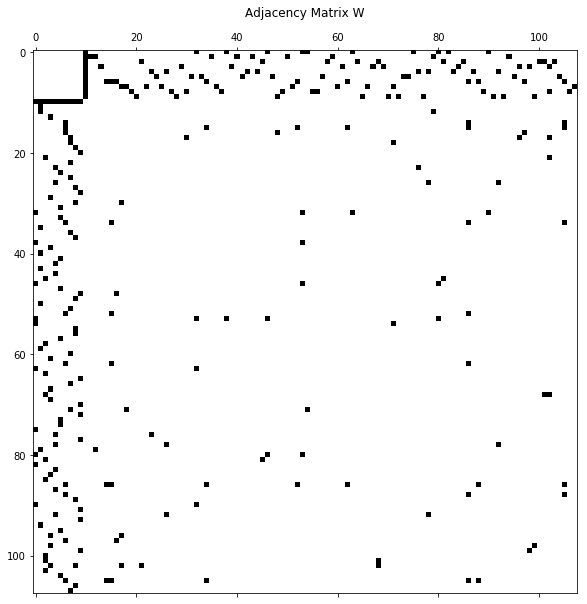

In [488]:
plt.figure(figsize=(10,10))
plt.spy(W)
plt.title('Adjacency Matrix W')

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

In [489]:
L = int(sum(sum(W))/2)
L_max = int(N*(N-1)/2)

print("L = ", L)
print("L_max = ", L_max)

L =  146
L_max =  5778


In theory : $L_{max}$ = $\left( \begin{matrix} N \\ 2 \end{matrix} \right)$ . As we can see L in much smaller than $L_{max}$. This means that the network is very sparse, but this is perfectly normal as we are studying a social network, and a very small sample of it. 


## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

In [490]:
p = sum(W) 
print(p)

[11 10 11 11 10 11 11 11 11 11 10  1  2  1  3  6  3  4  2  1  1  2  1  2  1
  1  3  1  1  1  2  1  4  1  4  1  1  1  2  1  1  1  1  1  1  2  3  1  2  1
  1  1  3  5  2  1  1  1  1  1  1  1  3  2  1  1  1  1  3  1  1  3  1  1  1
  1  2  1  3  2  3  2  1  1  1  1  8  1  3  1  2  1  3  1  1  1  2  2  2  2
  1  2  5  1  1  6  1  1]


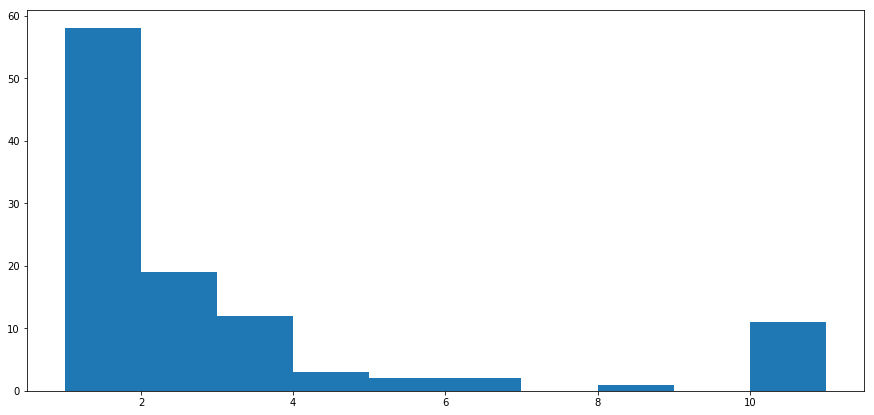

In [493]:
plt.figure(figsize=(15,7))
plt.hist(p);

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

We observe that the distrubtion is mainly constituted of single links. This is because we sample randomly the the network. In the real twitter network, we should see less single links. 

## 2.3 Average degree

Calculate the average degree of your collected network.

In [494]:
d_avg = sum(p)/N
d_avg

2.7037037037037037

## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

The diameter of the grah is the longest of the shortest path between 2 nodes. By construction the shortest path between 2 nodes of `first_nodes` will always pass through a the center of the network `user_id` or by a direct link : $d \leq 2$. The shortest path between two nodes of `second_node` would pass by a node of `first_nodes`or by the center of the network `user_id` : $d \leq 4$. So the longest of the shortest path would be the following diameter : $d_{max} =4$. 

## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [495]:
index_select = np.array([val >= d_avg for val in sum(W)])

Wpruned = W[index_select,:]
Wpruned = Wpruned[:,index_select]

<class 'list'>


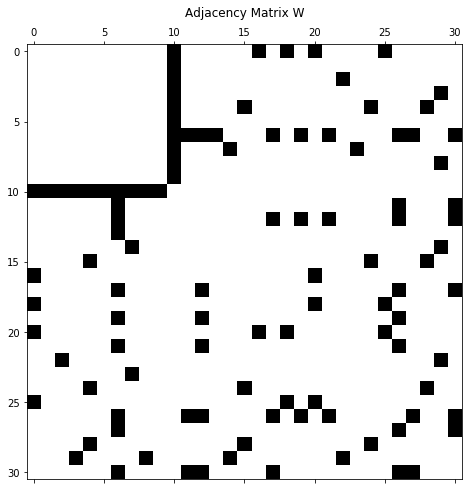

In [496]:
plt.figure(figsize=(8,8))
plt.spy(Wpruned)
plt.title('Adjacency Matrix W');

[ 5  1  2  2  4  1 10  3  2  1 10  3  6  1  2  3  2  4  3  3  4  3  2  1  3
  3  8  3  3  4  6]


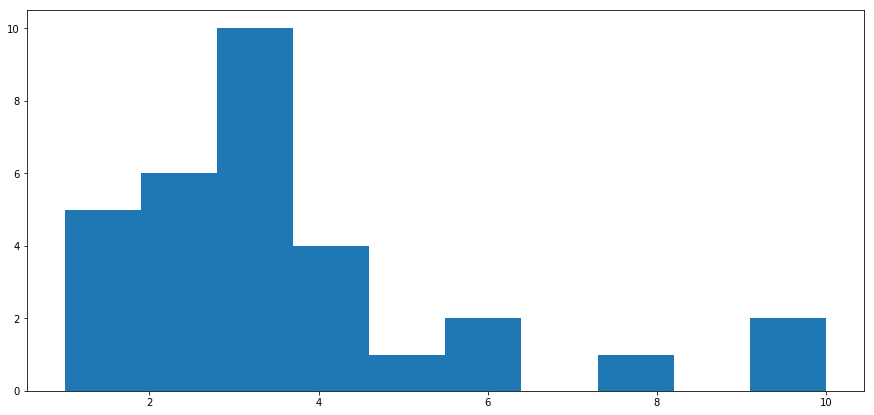

In [498]:
p_pruned = sum(Wpruned) 
print(p_pruned)
plt.figure(figsize=(15,7))
plt.hist(p_pruned);

As we see the shape of the matrix is less sparse than in the previous case, this is more similar to an actual real twitter network